# Libraries & Custom Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import r2_score, make_scorer, silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

In [6]:
#Need Special Care to not overwrite sklearn modules/classes that are also used in this notebook (& more frequently)
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic, KNNWithMeans, NMF, BaselineOnly
from surprise import model_selection as surprise_select
from surprise import accuracy as surprise_accuracy

from scipy.stats import norm

In [7]:
def count_outliers(df_col,cap=3):
    zs = zscore(df_col)
    return df_col[zs > cap].shape[0]

# Part 1--Wine Classifications
We classify wine based on their chemical properties.  Use some combination of k-NN and PCA and these basic steps:
1.  EDA & General Preprocessing.
2.  Apply PCA to reduce dimensionality with 95% retention rate.
3.  Optimized a KNN model with grid search--looking for optimal k and optimal distance metric.
4.  Train the KNN model based on (3).
5.  Evaluate w/ Classification & Accuracy Scoring

In [8]:
# Begin with loading the data.
_FILE_ = "wine_data.csv"
df = pd.read_csv(_FILE_)

## EDA

### Data Types, Observations, & Feature Space

In [9]:
N,dimensions = df.shape
print(f"There are {N} observations and {dimensions} features.")

There are 178 observations and 14 features.


In [10]:
df.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object

In [11]:
df.head(10)

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   
5    14.20        1.76  2.45               15.2      112.0           3.27   
6    14.39        1.87  2.45               14.6       96.0           2.50   
7    14.06        2.15  2.61               17.6      121.0           2.60   
8    14.83        1.64  2.17               14.0       97.0           2.80   
9    13.86        1.35  2.27               16.0       98.0           2.98   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   
5        3.39                  0.34             1.97             6.75  1.05   
6        2.52                  0.30             1.98             5.25  1.02   
7        2.51                  0.31             1.25             5.05  1.06   
8        2.98                  0.29             1.98             5.20  1.08   
9        3.15                  0.22             1.85             7.22  1.01   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0  
5                          2.85   1450.0       0  
6                          3.58   1290.0       0  
7                          3.58   1295.0       0  
8                          2.85   1045.0       0  
9                          3.55   1045.0       0

Only 178 observations will mean missing values and/or outliers need to be dealt with carefully in order to retain as much data as possible.  Only 14 features isn't too difficult but without more observations, it is certainly a good idea to reduce the feature space.  All of the features appear to be continuous variables and are properly typed in the dataset.

Create Lists of Different Categories of Features

In [12]:
_TARGET_ = 'target'
_FEATURES_ = ['alcohol','malic_acid','ash','alcalinity_of_ash','magnesium',
              'total_phenols','flavanoids','nonflavanoid_phenols','proanthocyanins',
              'color_intensity', 'hue','od280/od315_of_diluted_wines','proline'
              ]

_NUMERICS_ =  ['alcohol','malic_acid','ash','alcalinity_of_ash','magnesium',
              'total_phenols','flavanoids','nonflavanoid_phenols','proanthocyanins',
              'color_intensity', 'hue','od280/od315_of_diluted_wines','proline'
              ]

### Missing Values + Repeat Datapoints

In [13]:
print(df.isna().sum().sum())
df.isna().sum()

0


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [14]:
df.duplicated().sum()

0

Great.  Nothing to worry about with either issue.

### Taget Data

In [15]:
df[_TARGET_].value_counts(normalize=True)

target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64

While not perfect, I would argue that the class imbalance is insuffecient for requiring special attention.

### Input Features

#### Numerical Data
##### Distibutions

In [16]:
df[_NUMERICS_].describe()

alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       color_intensity         hue  od280/od315_of_diluted_wines      proline  
count       178.000000  178.000000                    178.000000   178.000000  
mean          5.058090    0.957449                      2.611685   746.893258  
std           2.318286    0.228572                      0.709990   314.907474  
min           1.280000    0.480000                      1.270000   278.000000  
25%           3.220000    0.782500                      1.937500   500.500000  
50%           4.690000    0.965000                      2.780000   673.500000  
75%           6.200000    1.120000                      3.170000   985.000000  
max          13.000000    1.710000                      4.000000  1680.000000

alcohol  malic_acid         ash  alcalinity_of_ash
count  178.000000  178.000000  178.000000         178.000000
mean    13.000618    2.336348    2.366517          19.494944
std      0.811827    1.117146    0.274344           3.339564
min     11.030000    0.740000    1.360000          10.600000
25%     12.362500    1.602500    2.210000          17.200000
50%     13.050000    1.865000    2.360000          19.500000
75%     13.677500    3.082500    2.557500          21.500000
max     14.830000    5.800000    3.230000          30.000000

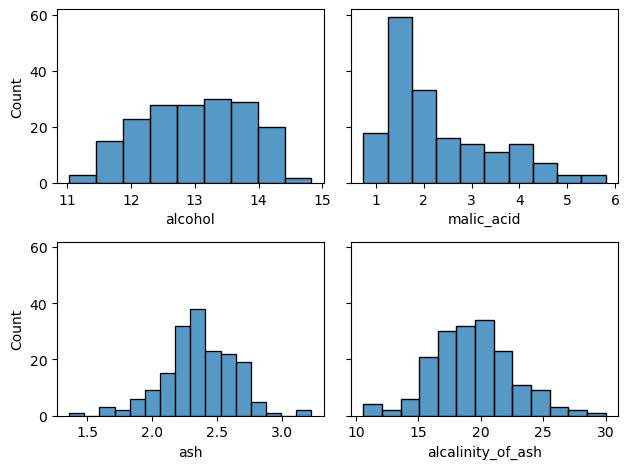

In [17]:
c=0
sub_cols = _NUMERICS_[c:c+4]
fig,axs=plt.subplots(ncols=2,nrows=2,sharey=True)
i=1
for ax in axs.ravel():
    if(i+c>len(_NUMERICS_)):
        break
    sns.histplot(df,x=_NUMERICS_[c+i-1],ax=ax)
    i+=1
plt.tight_layout()
df[_NUMERICS_[c:c+4]].describe()


ALCOHOL:  Relatively Normal

MALIC ACID:  

ASH:  Pretty darn normal.

ASH ALCALINITY:  Pretty darn normal.

magnesium  total_phenols  flavanoids  nonflavanoid_phenols
count  178.000000     178.000000  178.000000            178.000000
mean    99.741573       2.295112    2.029270              0.361854
std     14.282484       0.625851    0.998859              0.124453
min     70.000000       0.980000    0.340000              0.130000
25%     88.000000       1.742500    1.205000              0.270000
50%     98.000000       2.355000    2.135000              0.340000
75%    107.000000       2.800000    2.875000              0.437500
max    162.000000       3.880000    5.080000              0.660000

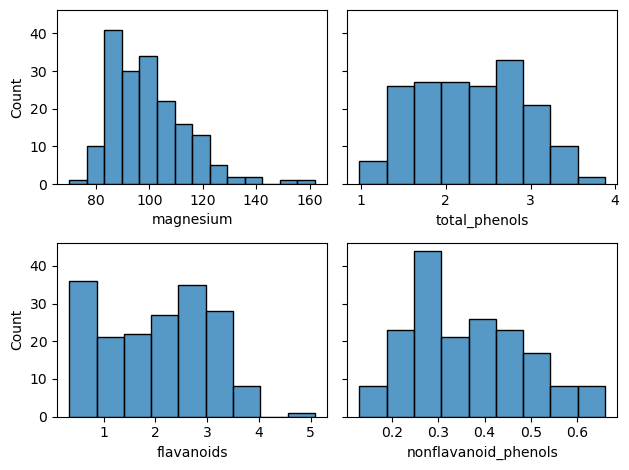

In [18]:
c=4
sub_cols = _NUMERICS_[c:c+4]
fig,axs=plt.subplots(ncols=2,nrows=2,sharey=True)
i=1
for ax in axs.ravel():
    if(i+c>len(_NUMERICS_)):
        break
    sns.histplot(df,x=_NUMERICS_[c+i-1],ax=ax)
    i+=1
plt.tight_layout()
df[_NUMERICS_[c:c+4]].describe()


MAGNESIUM: Roughly Normal.

TOTAL PHENOLS:  Tough to say.

FLAVANOIDS:  Tough to say.

NONFLAVANOID PHENOLS: Tough to say.

proanthocyanins  color_intensity         hue  \
count       178.000000       178.000000  178.000000   
mean          1.590899         5.058090    0.957449   
std           0.572359         2.318286    0.228572   
min           0.410000         1.280000    0.480000   
25%           1.250000         3.220000    0.782500   
50%           1.555000         4.690000    0.965000   
75%           1.950000         6.200000    1.120000   
max           3.580000        13.000000    1.710000   

       od280/od315_of_diluted_wines  
count                    178.000000  
mean                       2.611685  
std                        0.709990  
min                        1.270000  
25%                        1.937500  
50%                        2.780000  
75%                        3.170000  
max                        4.000000

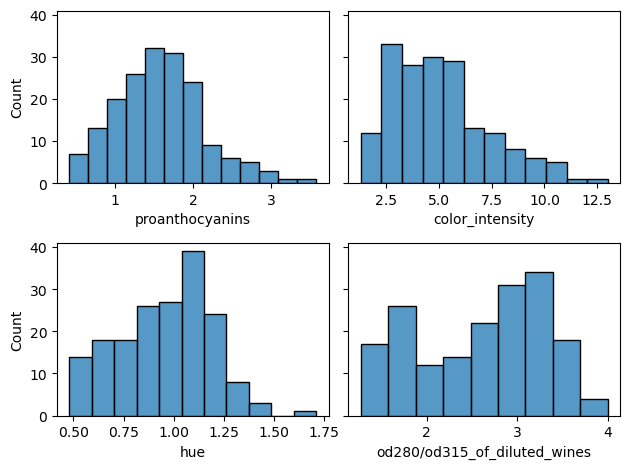

In [19]:
c=8
sub_cols = _NUMERICS_[c:c+4]
fig,axs=plt.subplots(ncols=2,nrows=2,sharey=True)
i=1
for ax in axs.ravel():
    if(i+c>len(_NUMERICS_)):
        break
    sns.histplot(df,x=_NUMERICS_[c+i-1],ax=ax)
    i+=1
plt.tight_layout()
df[_NUMERICS_[c:c+4]].describe()


PROANTHOCYANINS:  Looks petty normal.
COLOR INTENSITY:  Less clear.
HUE: w/ some skew, could be normal.
OD-Ratio: Impossible to say.

proline
count   178.000000
mean    746.893258
std     314.907474
min     278.000000
25%     500.500000
50%     673.500000
75%     985.000000
max    1680.000000

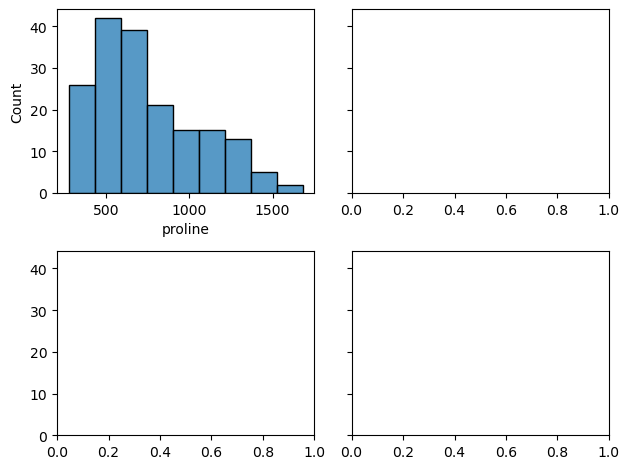

In [20]:
c=12
sub_cols = _NUMERICS_[c:c+4]
fig,axs=plt.subplots(ncols=2,nrows=2,sharey=True)
i=1
for ax in axs.ravel():
    if(i+c>len(_NUMERICS_)):
        break
    sns.histplot(df,x=_NUMERICS_[c+i-1],ax=ax)
    i+=1
plt.tight_layout()
df[_NUMERICS_[c:c+4]].describe()


Normal w/ skew?

#### Outliers

In [21]:
pd.DataFrame({c:{z:count_outliers(df[c],z) for z in [3,5,10,15,20]} for c in _NUMERICS_}).T

3   5   10  15  20
alcohol                        0   0   0   0   0
malic_acid                     1   0   0   0   0
ash                            2   0   0   0   0
alcalinity_of_ash              1   0   0   0   0
magnesium                      2   0   0   0   0
total_phenols                  0   0   0   0   0
flavanoids                     1   0   0   0   0
nonflavanoid_phenols           0   0   0   0   0
proanthocyanins                1   0   0   0   0
color_intensity                1   0   0   0   0
hue                            1   0   0   0   0
od280/od315_of_diluted_wines   0   0   0   0   0
proline                        0   0   0   0   0

Some outliers but none with too large of Z-Score.  Keep an eye out for them.

#### Correlations

In [22]:
inter_corr = df[_NUMERICS_].corr()

<Axes: >

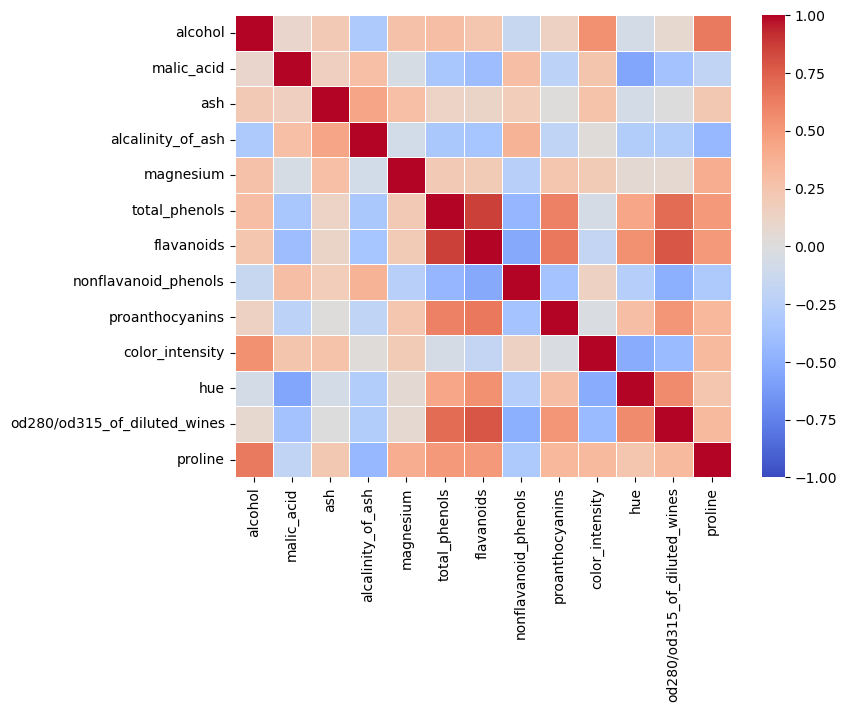

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(inter_corr, cmap='coolwarm', fmt=".2f", linewidths=.5,vmin=-1,vmax=1)

Nothing too concerning except for flavanoids and total phenols.  Maybe flavanoids and od-ratio.

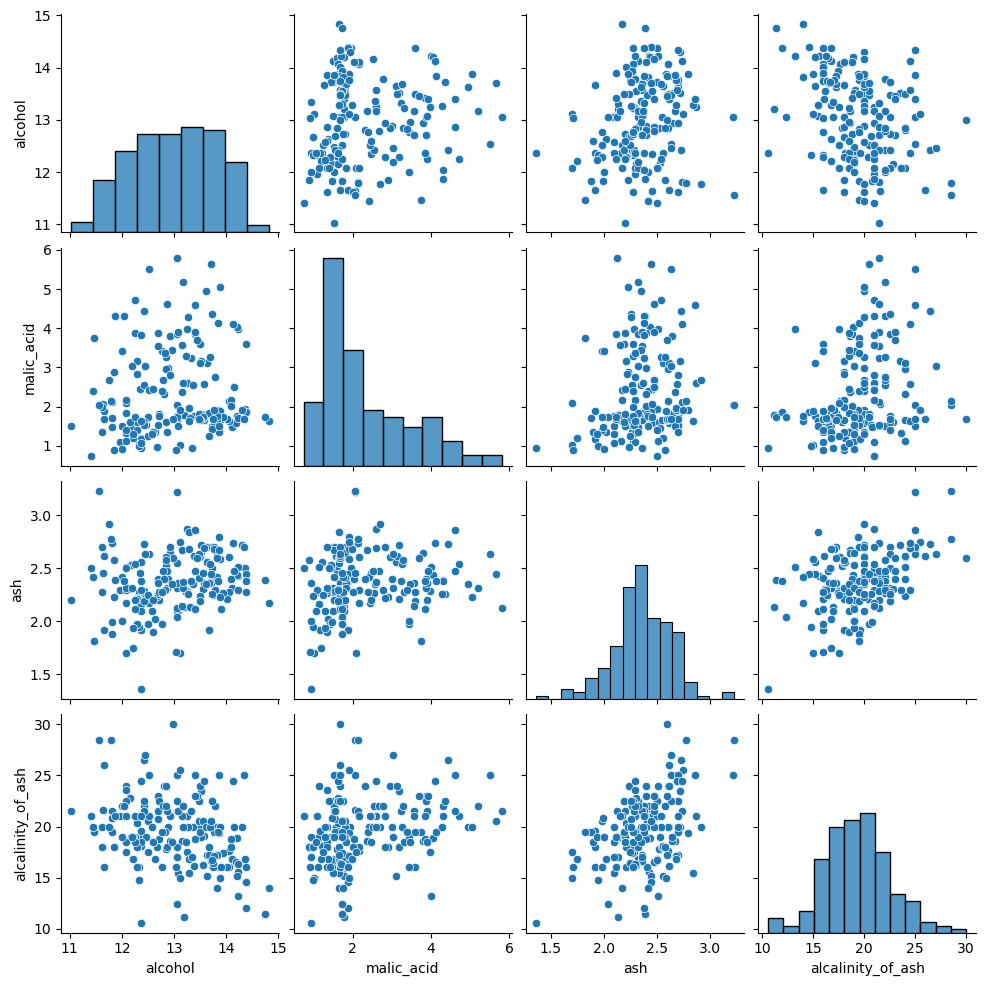

In [24]:
c=0
subset = df[_NUMERICS_[c:c+4]]
sns.pairplot(subset);

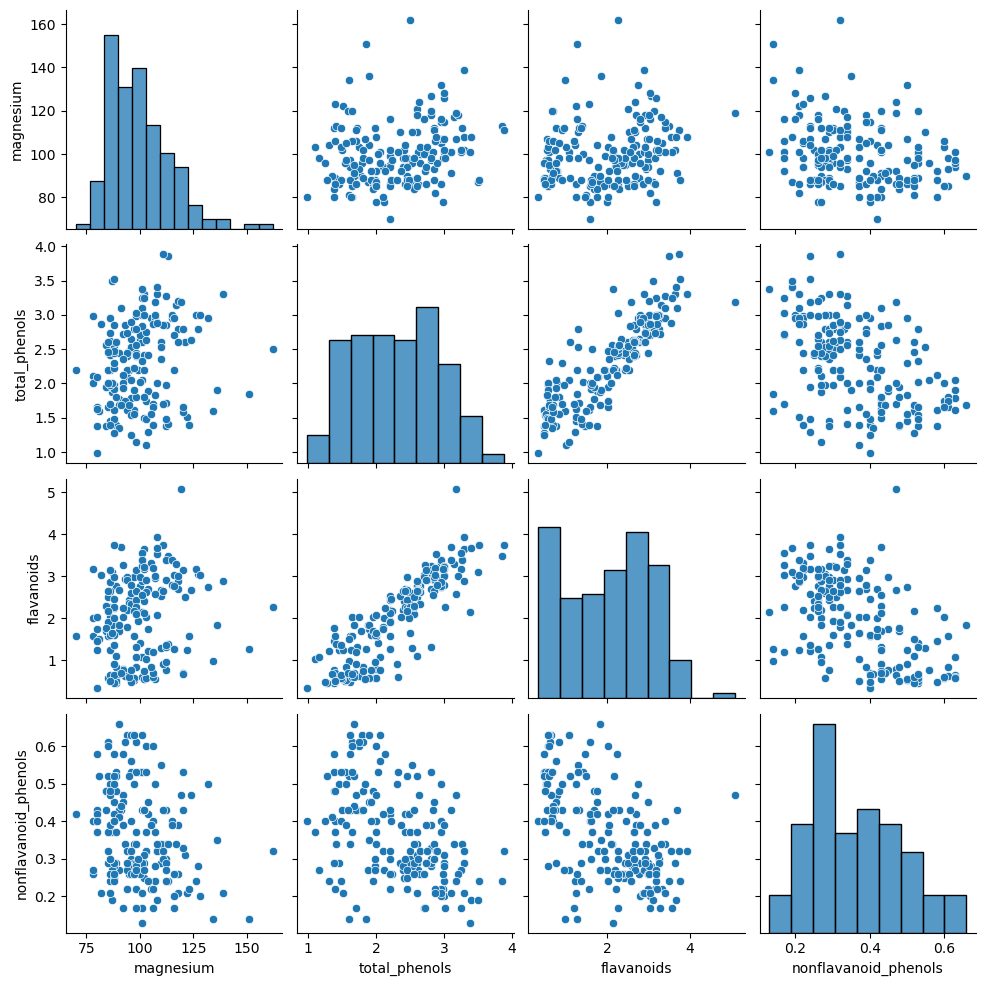

In [25]:
c=4
subset = df[_NUMERICS_[c:c+4]]
sns.pairplot(subset);

### Relationship Between Target & Inputs

#### Numericals

target                               0         1         2
alcohol                       0.916609 -0.889212  0.188627
malic_acid                   -0.291520 -0.361342  0.892812
ash                           0.324689 -0.443706  0.257219
alcalinity_of_ash            -0.735921  0.222509  0.575441
magnesium                     0.461923 -0.363542 -0.030042
total_phenols                 0.870906 -0.057904 -0.984839
flavanoids                    0.954192  0.051634 -1.249237
nonflavanoid_phenols         -0.577356  0.014528  0.688178
proanthocyanins               0.538863  0.068808 -0.764131
color_intensity               0.202829 -0.850400  1.008573
hue                           0.457557  0.432391 -1.201992
od280/od315_of_diluted_wines  0.769181  0.244604 -1.307262
proline                       1.171197 -0.722073 -0.371530


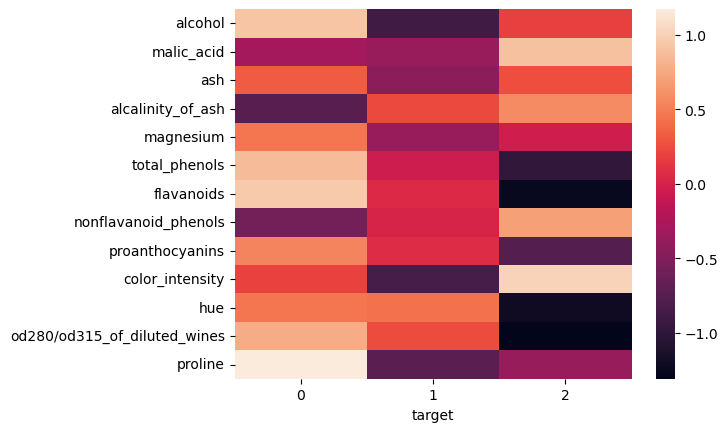

In [26]:
split_mean = df.groupby(_TARGET_)[_NUMERICS_].mean().T
means = df[_NUMERICS_].mean()
stdevs = df[_NUMERICS_].std()

split_mean_z = split_mean.apply(lambda c: (c-means)/stdevs)
print(split_mean_z)
sns.heatmap(split_mean_z);

Class 2 seems to have some especially distinct values for features like hue, od-ratio and flavanoids.

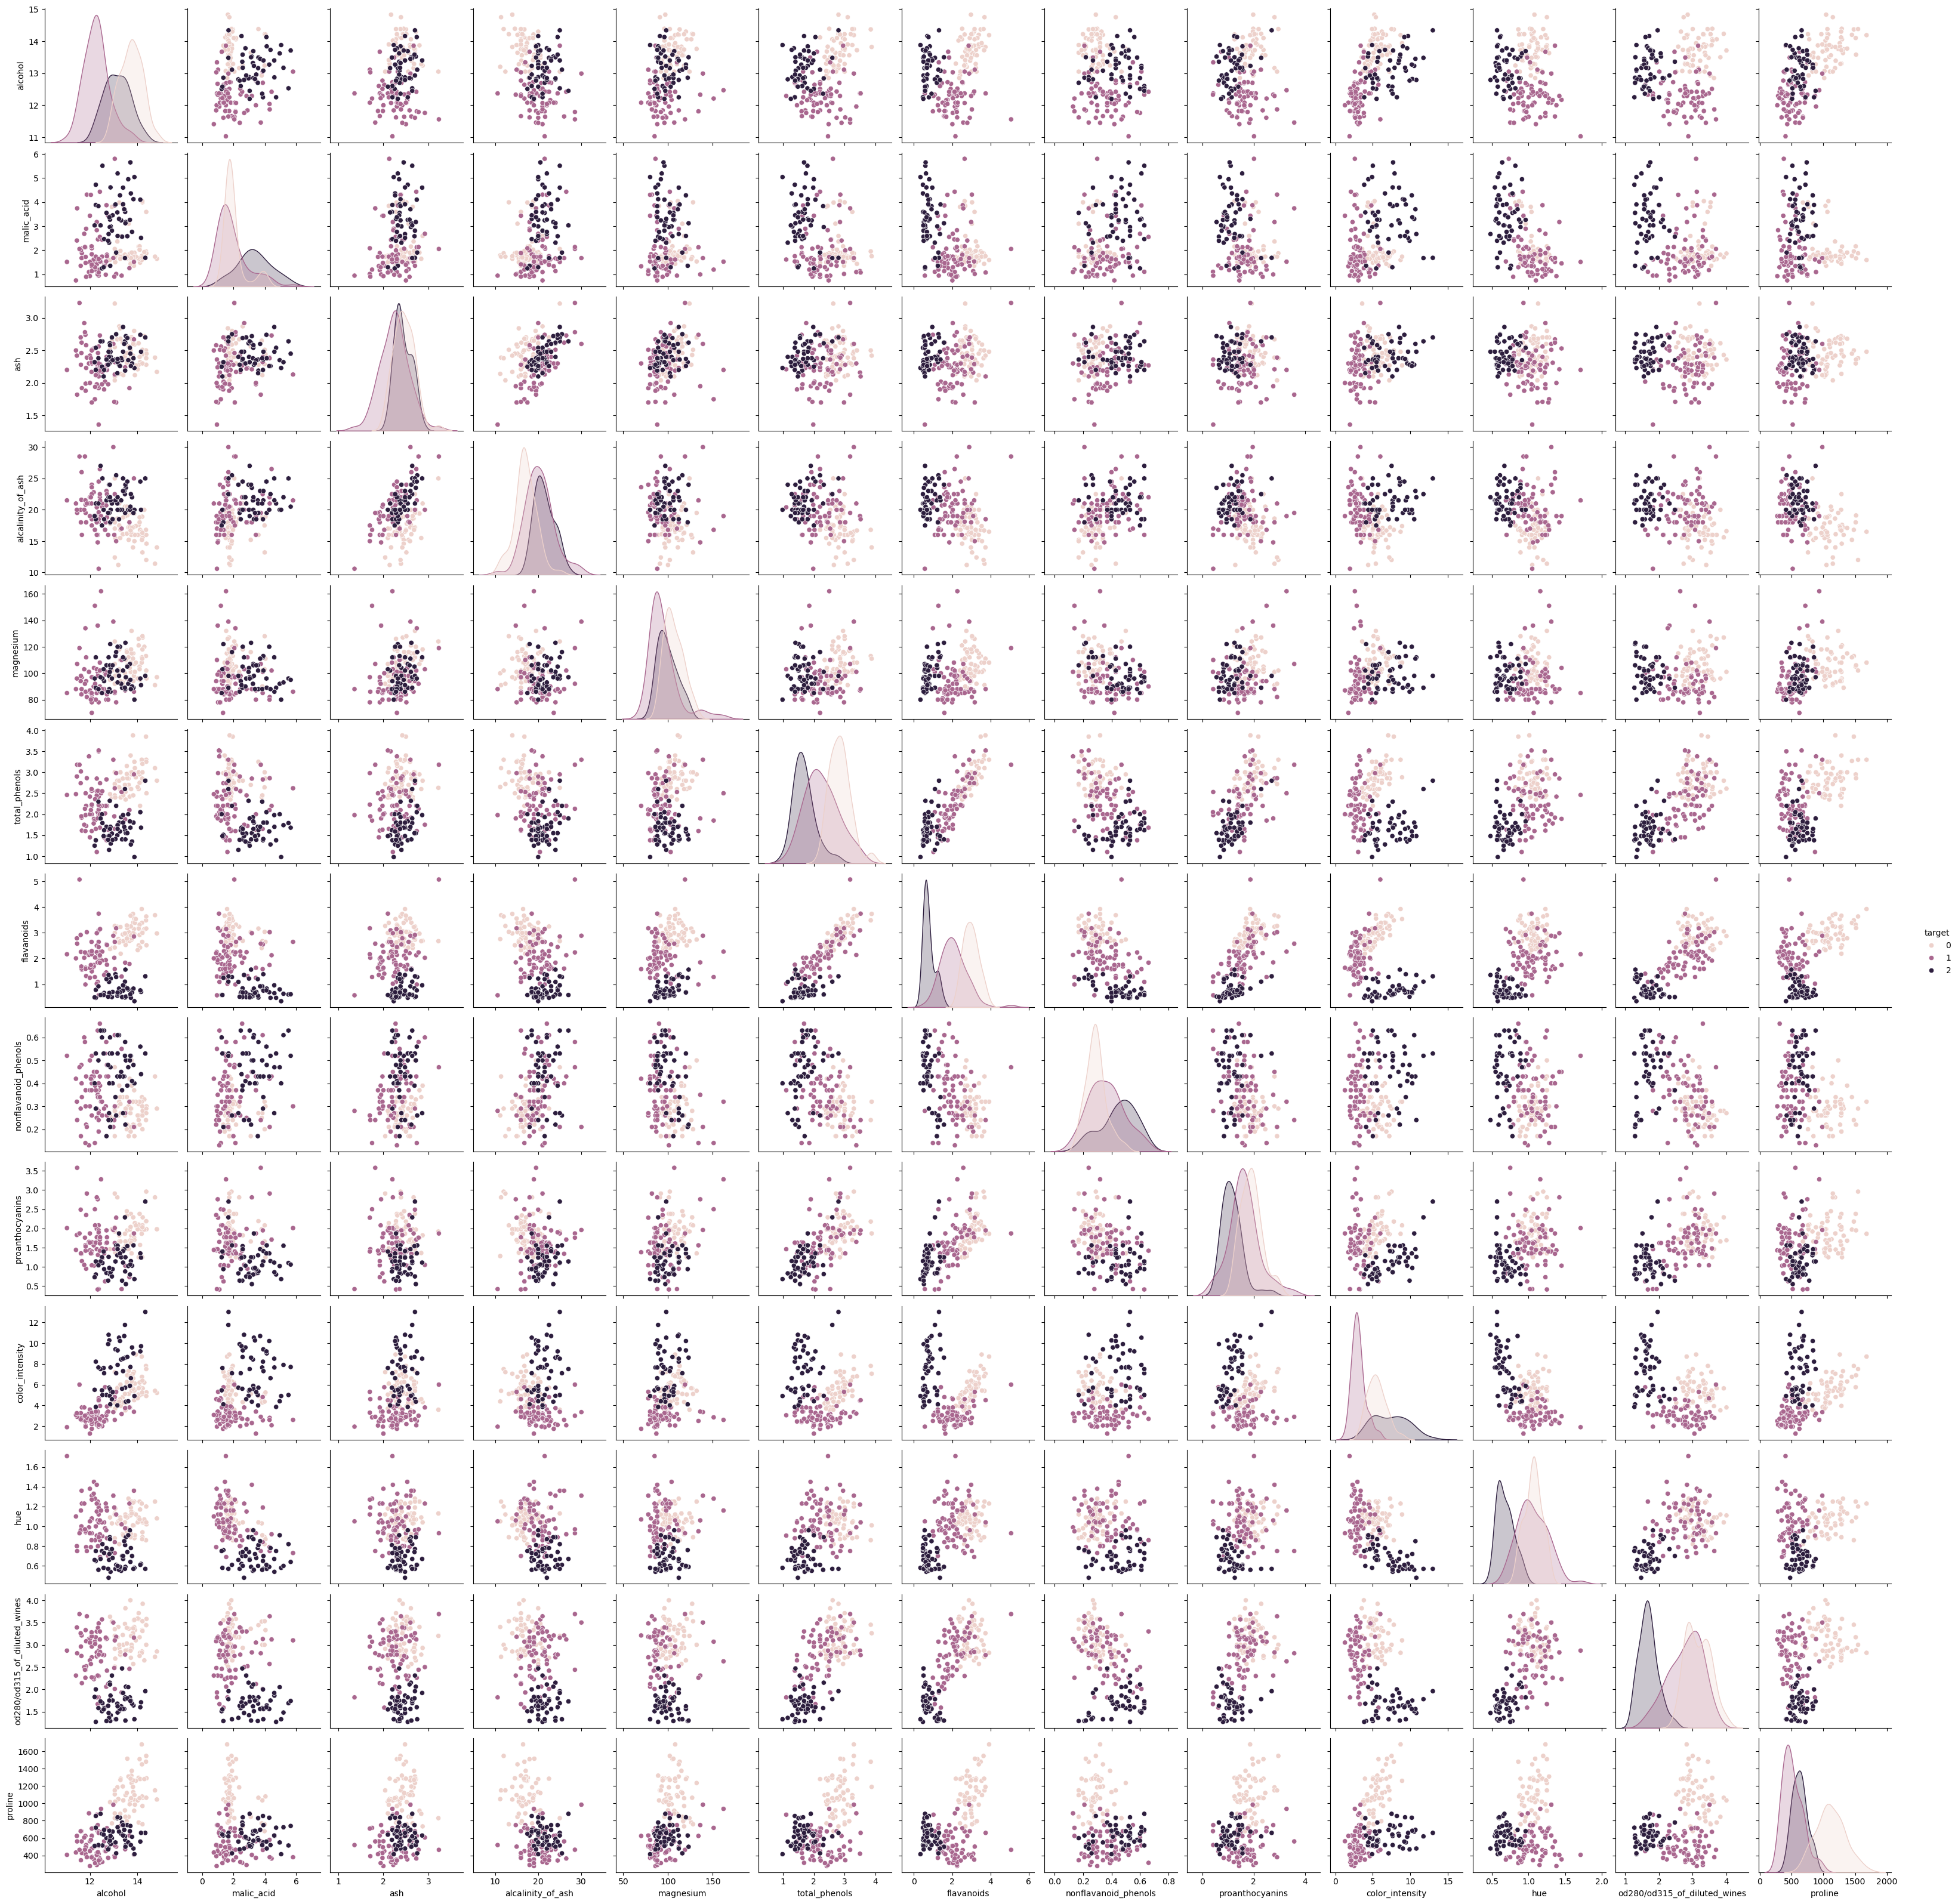

In [27]:
subset = df[_NUMERICS_+[_TARGET_]]
sns.pairplot(subset,hue=_TARGET_);

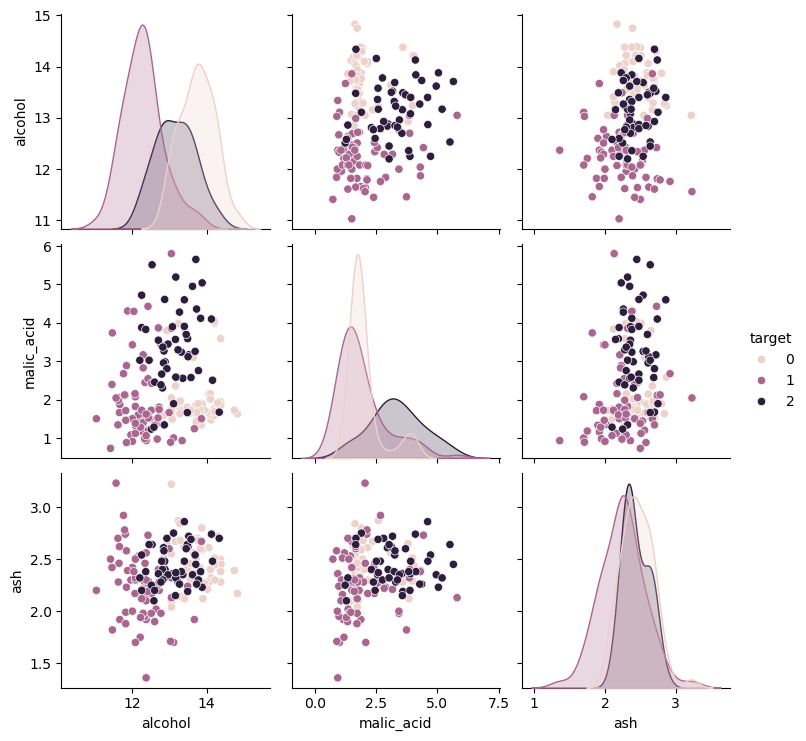

In [28]:
c=0
subset = df[_NUMERICS_[c:c+3]+[_TARGET_]]
sns.pairplot(subset,hue=_TARGET_);

ALCOHOL: Similarly shaped distributions with obvious shifts in the mean. Two of the classes intersect pretty cleanly with the third.

MALIC ACID:  Class 2 seems cleanly normalized but not so clear for the distribution in the other two classes.

ASH:  Very little distinction between the classes.

CROSS-FEATURE OBSERVATIONS: Nothing really clearly delineates any of the classes.


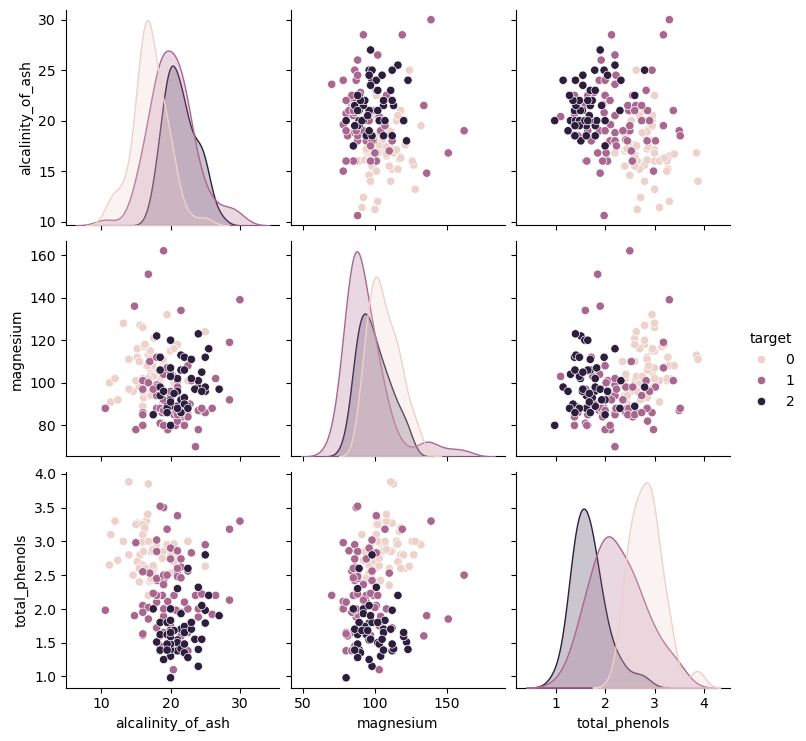

In [29]:
c=3
subset = df[_NUMERICS_[c:c+3]+[_TARGET_]]
sns.pairplot(subset,hue=_TARGET_);

ASH ALCALINITY & MAGNESIUM: Both have very similar distributions.

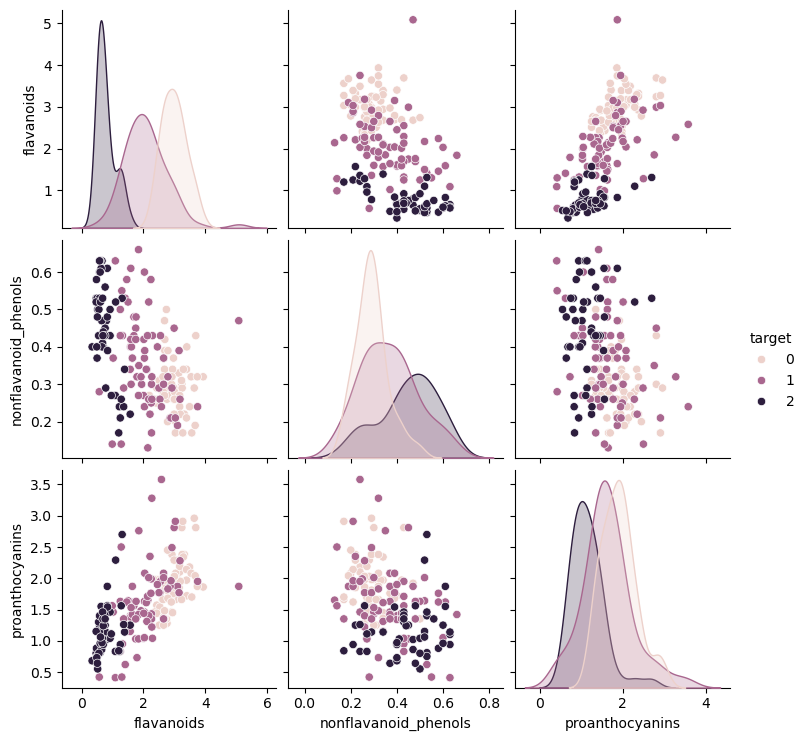

In [30]:
c=6
subset = df[_NUMERICS_[c:c+3]+[_TARGET_]]
sns.pairplot(subset,hue=_TARGET_);

FLAVANOIDS:

NONFLAVANOID PHENOLS: Very clear distributions

PROANTHOCYANINS:


CROSS-FEATURE OBSERVATIONS: With the flavanoids interactions, we seem to get some speration between the classes.

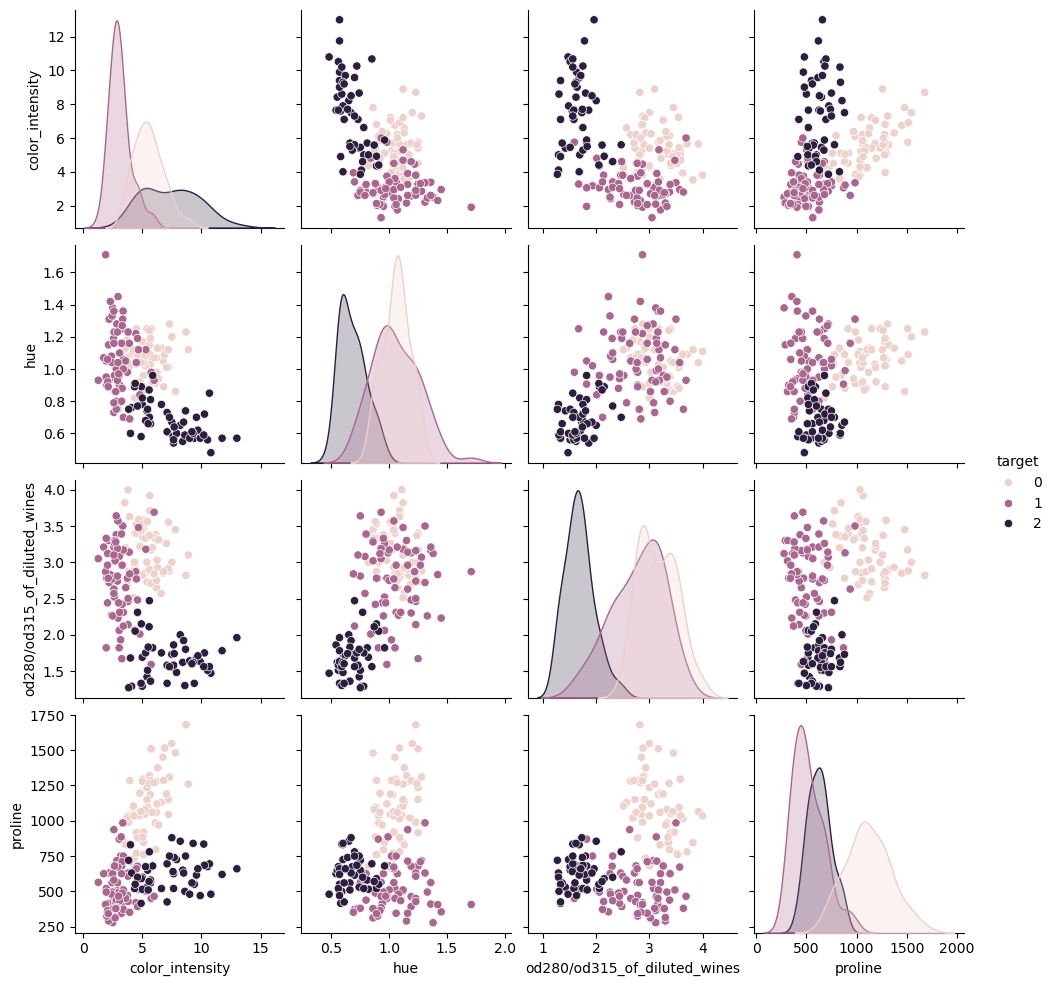

In [31]:
c=9
subset = df[_NUMERICS_[c:c+4]+[_TARGET_]]
sns.pairplot(subset,hue=_TARGET_);

CROSS-FEATURE OBSERVATIONS: Really start to see some seperation between classes (even if there is some overlap between 2 at a time).

## PCA Exploration
As discussed above, there does not appear to be too much of a risk for multicolinearirty and the feature space, without context, appears to be managable.  However, relative to the number of observations, the feature space may be too large.

### Preprocessing / Cleaning
To maintain data integrity, we will need to reread the csv file.

In [32]:
del df

In [33]:
df = pd.read_csv(_FILE_)

We discovered in the EDA phase that this data is pretty clean with no missing values, no strings (requiring conversions) and no mistyping.

Except for the target variable, we do not have any categorical data to handle.

All this is to say, we can limit our preprocessing step to splitting and scalling the data, the former will also need to be done to seperate the train and test sets when training the k-NN model.  Although, there is a question as to the appropriate scaling technique.

In [34]:
X = df.drop(_TARGET_,axis=1)
y = df[_TARGET_].copy()

In [35]:
X_std = StandardScaler().fit_transform(X)

### Fit a Generic PCA Model to features data.  

In [36]:
pca = PCA()
pca.fit(X_std);


Since the assignment at hand specifically mentions the requirement to keep 95% of info, let us just examine the cumulative variance plot to determine how many components we will be considering.

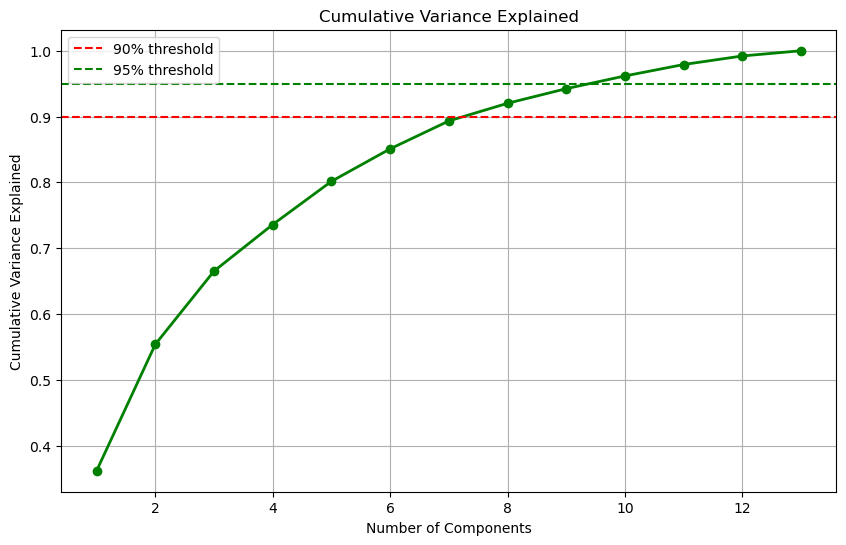

In [37]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
# Create a cumulative variance plot
plt.figure(figsize=(10, 6))
cum_var_plot = plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 
         'o-', linewidth=2, color='green')
# Add lines for 90% and 95% thresholds
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
target_variance = 0.95
n_components_variance = np.argmax(cumulative_var >= target_variance) + 1
print(f'We choose to include the first {n_components_variance} components.')

We choose to include the first 10 components.


### Inspect New Features

In [39]:
pca = PCA(n_components=n_components_variance)
pca.fit(X_std);

In [40]:
# Transform the standardized data to get principal components
X_pca = pca.transform(X_std)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    3.316751  1.443463 -0.165739 -0.215631  0.693043  0.223880  0.596427   
1    2.209465 -0.333393 -2.026457 -0.291358 -0.257655  0.927120  0.053776   
2    2.516740  1.031151  0.982819  0.724902 -0.251033 -0.549276  0.424205   
3    3.757066  2.756372 -0.176192  0.567983 -0.311842 -0.114431 -0.383337   
4    1.008908  0.869831  2.026688 -0.409766  0.298458  0.406520  0.444074   
..        ...       ...       ...       ...       ...       ...       ...   
173 -3.370524  2.216289 -0.342570  1.058527 -0.574164  1.108788  0.958416   
174 -2.601956  1.757229  0.207581  0.349496  0.255063  0.026465  0.146894   
175 -2.677839  2.760899 -0.940942  0.312035  1.271355 -0.273068  0.679235   
176 -2.387017  2.297347 -0.550696 -0.688285  0.813955 -1.178783  0.633975   
177 -3.208758  2.768920  1.013914  0.596903 -0.895193 -0.296092  0.005741   

          PC8       PC9      PC10  
0   -0.065139 -0.641443  1.020956  
1   -1.024416  0.308847  0.159701  
2    0.344216  1.177834  0.113361  
3   -0.643593 -0.052544  0.239413  
4   -0.416700 -0.326819 -0.078366  
..        ...       ...       ...  
173  0.146097  0.022498 -0.304117  
174  0.552427  0.097969 -0.206061  
175 -0.047024 -0.001222 -0.247997  
176 -0.390829 -0.057448  0.491490  
177  0.292914 -0.741660 -0.117969  

[178 rows x 10 columns]

In [41]:
# Create an easy to view DF of the loadings.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_variance)],
    index=_NUMERICS_
)
loadings

PC1       PC2       PC3       PC4  \
alcohol                       0.144329  0.483652 -0.207383 -0.017856   
malic_acid                   -0.245188  0.224931  0.089013  0.536890   
ash                          -0.002051  0.316069  0.626224 -0.214176   
alcalinity_of_ash            -0.239320 -0.010591  0.612080  0.060859   
magnesium                     0.141992  0.299634  0.130757 -0.351797   
total_phenols                 0.394661  0.065040  0.146179  0.198068   
flavanoids                    0.422934 -0.003360  0.150682  0.152295   
nonflavanoid_phenols         -0.298533  0.028779  0.170368 -0.203301   
proanthocyanins               0.313429  0.039302  0.149454  0.399057   
color_intensity              -0.088617  0.529996 -0.137306  0.065926   
hue                           0.296715 -0.279235  0.085222 -0.427771   
od280/od315_of_diluted_wines  0.376167 -0.164496  0.166005  0.184121   
proline                       0.286752  0.364903 -0.126746 -0.232071   

                                   PC5       PC6       PC7       PC8  \
alcohol                      -0.265664  0.213539 -0.056396  0.396139   
malic_acid                    0.035214  0.536814  0.420524  0.065827   
ash                          -0.143025  0.154475 -0.149171 -0.170260   
alcalinity_of_ash             0.066103 -0.100825 -0.286969  0.427970   
magnesium                     0.727049  0.038144  0.322883 -0.156361   
total_phenols                -0.149318 -0.084122 -0.027925 -0.405934   
flavanoids                   -0.109026 -0.018920 -0.060685 -0.187245   
nonflavanoid_phenols         -0.500703 -0.258594  0.595447 -0.233285   
proanthocyanins               0.136860 -0.533795  0.372139  0.368227   
color_intensity              -0.076437 -0.418644 -0.227712 -0.033797   
hue                          -0.173615  0.105983  0.232076  0.436624   
od280/od315_of_diluted_wines -0.101161  0.265851 -0.044764 -0.078108   
proline                      -0.157869  0.119726  0.076805  0.120023   

                                   PC9      PC10  
alcohol                      -0.508619  0.211605  
malic_acid                    0.075283 -0.309080  
ash                           0.307694 -0.027125  
alcalinity_of_ash            -0.200449  0.052799  
magnesium                    -0.271403  0.067870  
total_phenols                -0.286035 -0.320131  
flavanoids                   -0.049578 -0.163151  
nonflavanoid_phenols         -0.195501  0.215535  
proanthocyanins               0.209145  0.134184  
color_intensity              -0.056218 -0.290775  
hue                          -0.085828 -0.522399  
od280/od315_of_diluted_wines -0.137227  0.523706  
proline                       0.575786  0.162116

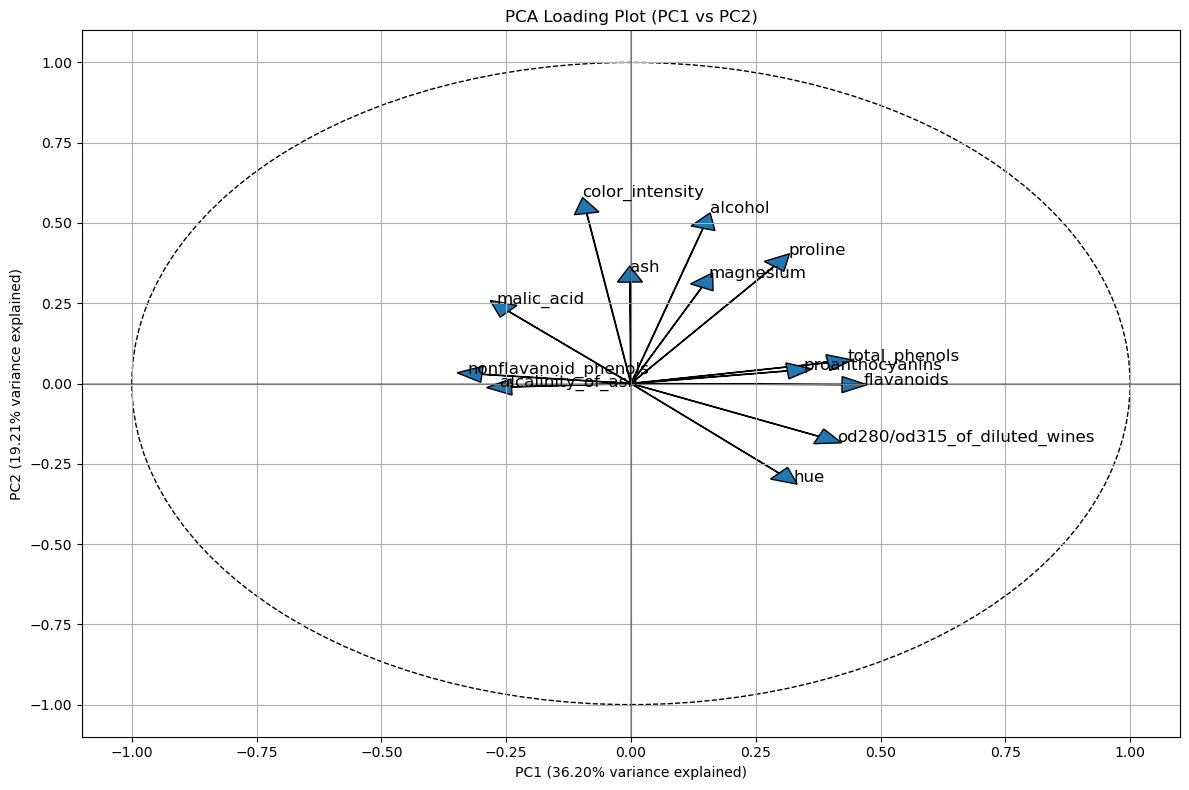

In [42]:
# Visualize the loadings for the first two PCs
plt.figure(figsize=(12, 8))
for i, feature in enumerate(_NUMERICS_):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0]*1.1, loadings.iloc[i, 1]*1.1, feature, fontsize=12)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title('PCA Loading Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.tight_layout()
plt.show()

## Build the Final Model
Once again, reupload the data to keep a clean database.

In [43]:
del df

In [44]:
df = pd.read_csv(_FILE_)

### Preprocess
And go through cleanup steps (if not in pipelines...):
1. Split the data into features and target; THEN to training and testing.
2. Create the scaler and fit it to the training data.
3. Create the PCA model, fit it to the scaled training data.
4. Transform the test data with the scaler and PCA Model.

In [45]:
X = df[_NUMERICS_]
y = df['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.75,random_state=42)

In [47]:
scaler = StandardScaler()
pca = PCA(n_components=n_components_variance)

In [48]:
scaler.fit(X_train);
pca.fit(X_train);

In [49]:
X_train = scaler.transform(X_train)
X_train = pca.transform(X_train)

X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Build the Model w/ grid search

In [50]:
knn=KNeighborsClassifier()
param_grid = {'n_neighbors':[1,3,5,7,9],
              #'weights':['uniform','distance'],
              'metric':['euclidean','manhattan','cosine']
              }

In [51]:
grid_search = GridSearchCV(knn,param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=-1) 

### Train The Models & Select Best Option

In [52]:
grid_search.fit(X_train, y_train)
best_parms = grid_search.best_params_
best_scores = grid_search.best_score_
print(f"Best parameters: {best_parms}")
print(f"Best cross-validation accuracy: {best_scores:.4f}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best cross-validation accuracy: 0.9775


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [53]:
final_model = grid_search.best_estimator_

### Look @ Results Against Test

In [54]:
# Make predictions on test set
y_pred = final_model.predict(X_test)

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_pred=y_pred,y_true=y_test)

# Create confusion matrix
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

Test set accuracy: 0.9778

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



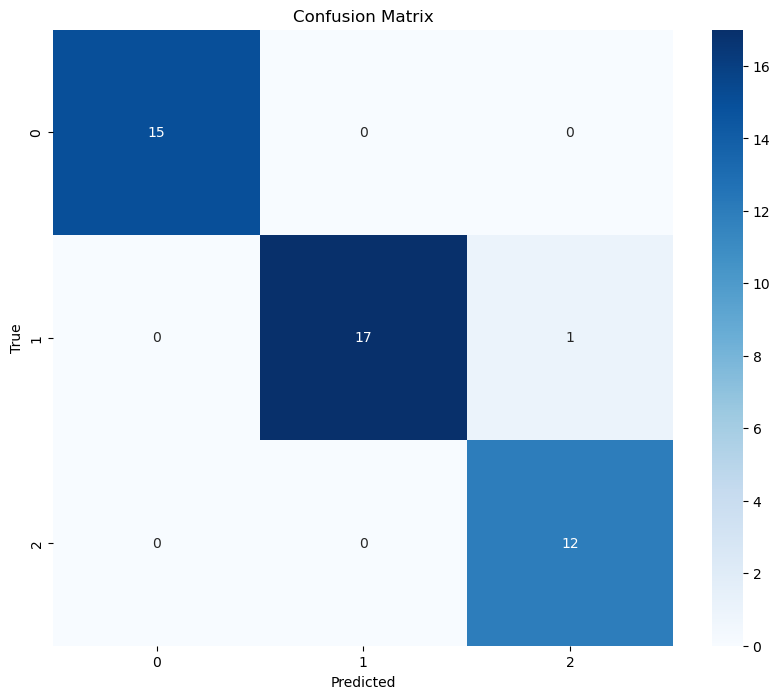

In [55]:
print(f"Test set accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

A very accurate classifier!  

## Final Training

In [56]:
del df

In [57]:
df = pd.read_csv(_FILE_)
X = df.drop(_TARGET_,axis=1)
y = df[_TARGET_].copy()

In [58]:
scaler = StandardScaler()
pca = PCA(n_components=n_components_variance)

In [59]:
scaler.fit(X);
pca.fit(X);

In [60]:
X = scaler.transform(X)
X = pca.transform(X)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [61]:
final_model.fit(X,y);

# Part 2--Agricultural Feed Recommendations
We want to build a recommendation engine to match farmers with feed types.  Recommendations will be based on identifying seed types that are similar to one another. We will also leverage PCA to build a lower-dimensional (1D?) feature space to feed into the engine which will rely upon cosine similarities.

Formally, we will be taking the following steps:
1.  EDA
2.  Basic Preprocessing (including standradizing the weight featue for uniform scalin)
3.  Analyze Dimensionality Reduction Options (& Apply if Needed)
4.  Compute similarities between different feed types (cosine similaity)
5.  Choose an algorithm.
6.  Analyze Results


In [62]:
del df

In [63]:
_FILE_ = "chickwts_data.csv"
df = pd.read_csv(_FILE_)

## EDA

In [64]:
N,dimensions = df.shape
print(f"There are {N} observations and {dimensions} features.")

There are 71 observations and 2 features.


In [65]:
df.dtypes

weight     int64
feed      object
dtype: object

In [66]:
df.head(10)

weight       feed
0     179  horsebean
1     160  horsebean
2     136  horsebean
3     227  horsebean
4     217  horsebean
5     168  horsebean
6     108  horsebean
7     124  horsebean
8     143  horsebean
9     140  horsebean

In [67]:
df.feed.value_counts()

feed
soybean      14
linseed      12
sunflower    12
casein       12
meatmeal     11
horsebean    10
Name: count, dtype: int64

In [68]:
df.isna().sum()

weight    0
feed      0
dtype: int64

In [69]:
df.groupby('feed').mean()

weight
feed                 
casein     323.583333
horsebean  160.200000
linseed    218.750000
meatmeal   276.909091
soybean    246.428571
sunflower  328.916667

In [70]:
df.groupby('feed').std()

weight
feed                
casein     64.433840
horsebean  38.625841
linseed    52.235698
meatmeal   64.900623
soybean    54.129068
sunflower  48.836384

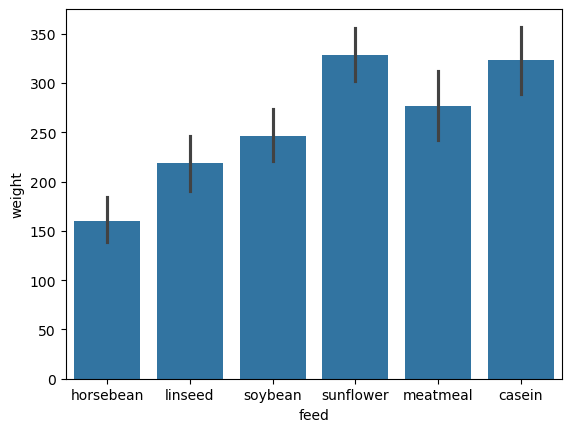

In [71]:
sns.barplot(x='feed',y='weight',data=df);

What is going on with this dataset?  There is only two features, one of which is categorical so there is no way to develop a recommendation engine.  Using PCA analysis doesn't make much sense, even after encoding the dataset to increase the feature space dimensionality.  

In [72]:
encoder = OneHotEncoder(sparse_output=False,drop='first')
encoded_feed = encoder.fit_transform(df[['feed']])

scaler = StandardScaler()
scaled_weight = scaler.fit_transform(df[['weight']])

In [73]:
# Combine numerical and categorical features
normalized_features = np.hstack((scaled_weight, encoded_feed))

# Create a list of feature names for the encoded data
encoded_feature_names = list(encoder.get_feature_names_out())
features = ['Weight_Std'] + encoded_feature_names


features_df = pd.DataFrame(normalized_features,columns=features)
features_df.head()

Weight_Std  feed_horsebean  feed_linseed  feed_meatmeal  feed_soybean  \
0   -1.061762             1.0           0.0            0.0           0.0   
1   -1.306854             1.0           0.0            0.0           0.0   
2   -1.616444             1.0           0.0            0.0           0.0   
3   -0.442583             1.0           0.0            0.0           0.0   
4   -0.571578             1.0           0.0            0.0           0.0   

   feed_sunflower  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

In [74]:
pca=PCA(n_components=1)
data_transformed = pca.fit_transform(features_df)

In [75]:
pd.DataFrame(data_transformed).describe()

0
count  7.100000e+01
mean  -4.847453e-17
std    1.042815e+00
min   -2.074375e+00
25%   -7.573876e-01
50%   -5.117379e-04
75%    8.630817e-01
max    2.186289e+00

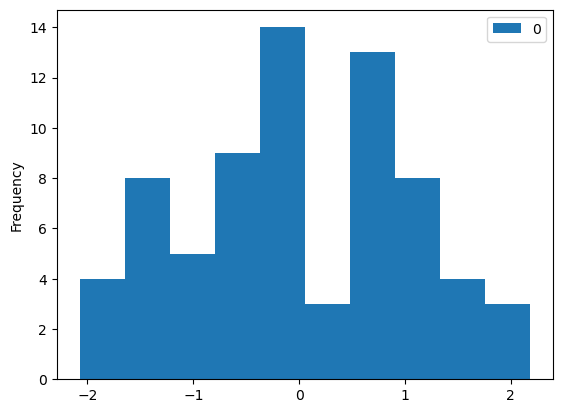

In [76]:
pd.DataFrame(data_transformed).plot.hist();

In [77]:
cosine_diff = 1 - cosine_similarity(data_transformed)
eucl_diff = euclidean_distances(data_transformed)
grid_diff = manhattan_distances(data_transformed)

Cosine Similarities/Differences make no sense in a 1-dimensional world.  They are just +/- 1 depending on if the two observations have the same sign (ie. they point in the same direction along the number line...)

Manhattan and Euclidean don't differ in 1-dimensional space (the number line).

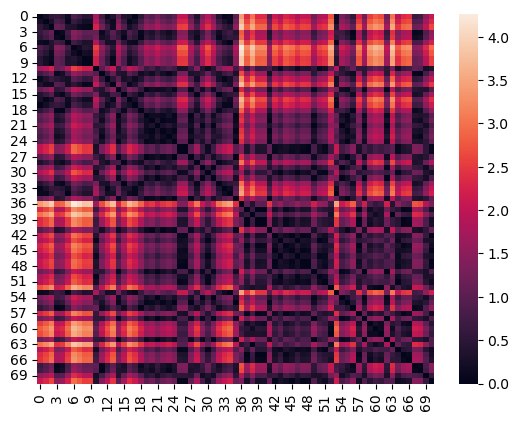

In [78]:
sns.heatmap(pd.DataFrame(eucl_diff));

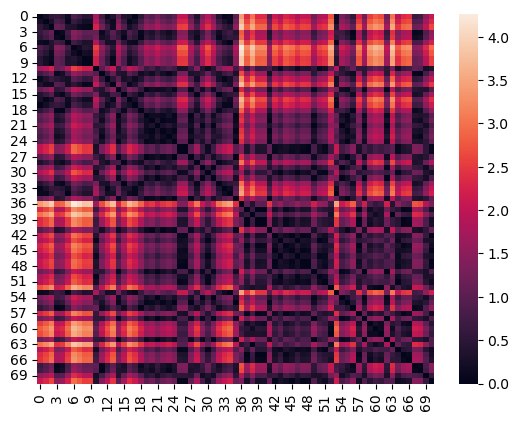

In [79]:
sns.heatmap(pd.DataFrame(grid_diff));

## Recommendation Functions
It is not clear to me that this data is appropriate for a recommendation engine since we cannot build a 2-dimensional matrix with the given features.  But let's ignore that and create a function that will take a target weight for the chicken to grow and spit out a feed label based on the observations provided.  
(I thought about creating a second function that would try to take the earlier work but it doesn't make sense to feed a recommendation system the feed type and weight gained and ask for what?)

In [80]:
# Gather the original data
df =pd.read_csv(_FILE_)
#Scale
scaler = StandardScaler()
df['weight_scaled'] = scaler.fit_transform(df[['weight']])

feeds = list(df.feed.value_counts().index)
distributions=dict.fromkeys(feeds)

In [81]:
# train the data
for feed in feeds:
    data = df[df['feed']==feed]['weight_scaled'].copy()
    distributions[feed] = (data.mean(),data.std())


In [82]:
x_mean = df['weight'].mean()
x_std = df['weight'].std()
def recommendation(weight):
    likelihoods=dict.fromkeys(feeds)
    z = (weight - x_mean)/x_std
    for feed in feeds:
        parms = distributions[feed]
        likelihoods[feed] = norm.pdf(z,parms[0],parms[1])
    most_likely = max(likelihoods.keys(),key = lambda f:likelihoods[f])
    return most_likely,likelihoods

In [86]:
recommendation(120)

('horsebean',
 {'soybean': 0.038986354619505524,
  'linseed': 0.10278445068636194,
  'sunflower': 7.338780142491372e-05,
  'casein': 0.0034251412957377715,
  'meatmeal': 0.02660264340500196,
  'horsebean': 0.47839946279712786})

# Part 3--Crime Clustering
We are interested in understanding regional trends/patterns in crime daata.  To uncover such patters in this unlabled data, we will consider both K-Means and Gausian Mixture Models.  We will also explore a few options for reducing the feature space dimensionality:
1.  Manually select features based on domain knowledge and observations in the EDA step.
2.  PCA 
3.  Some combination of both.

To do so, we will follow these steps:
1.  EDA
2.  Preprocessing
3.  Dimensionality Reduction Options:
    1. Choose three features most relevant for clustering
    2. Apply PCA to map the feature space to two dimensions.  
    3. Apply PCA to map the subset feature space from (1) to a two-dimensional space.
4.  Tune the number of clusters for each model:
    1. Use the elbow method for K-Means
    2. Use BIC for GMM
5. Compare the Results w/ Visuals
First upload the data.

But first, upload the data.

In [87]:
del df

In [88]:
_FILE_ = "arrests_data.csv"
df = pd.read_csv(_FILE_)

## EDA

### Data Types, Observations, & Feature Space

In [89]:
N,dimensions = df.shape
print(f"There are {N} observations and {dimensions} features.")

There are 50 observations and 5 features.


In [90]:
df.dtypes

Unnamed: 0     object
Murder        float64
Assault         int64
UrbanPop        int64
Rape          float64
dtype: object

In [91]:
df.head(10)

Unnamed: 0  Murder  Assault  UrbanPop  Rape
0      Alabama    13.2      236        58  21.2
1       Alaska    10.0      263        48  44.5
2      Arizona     8.1      294        80  31.0
3     Arkansas     8.8      190        50  19.5
4   California     9.0      276        91  40.6
5     Colorado     7.9      204        78  38.7
6  Connecticut     3.3      110        77  11.1
7     Delaware     5.9      238        72  15.8
8      Florida    15.4      335        80  31.9
9      Georgia    17.4      211        60  25.8

Can immediately fix the category of state even though it does not offer any new info. Everything else looks pretty straight-forward.

In [92]:
df = df.rename(columns={'Unnamed: 0':'State'})

In [93]:
_FEATURES_ = ['Murder','Assault','UrbanPop','Rape']

In [94]:
df[_FEATURES_].describe()

Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000

### Missing Values + Repeat Datapoints

In [95]:
df.isna().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [96]:
df.duplicated().sum()

0

### Outliers

In [97]:
pd.DataFrame({c:{z:count_outliers(df[c],z) for z in [3,5,10,15,20]} for c in _FEATURES_}).T

3   5   10  15  20
Murder     0   0   0   0   0
Assault    0   0   0   0   0
UrbanPop   0   0   0   0   0
Rape       0   0   0   0   0

Nothing across all of this typical issues.

### Feature Distributions & Correlations

In [98]:
inter_corr = df[_FEATURES_].corr()
inter_corr

Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000

<Axes: >

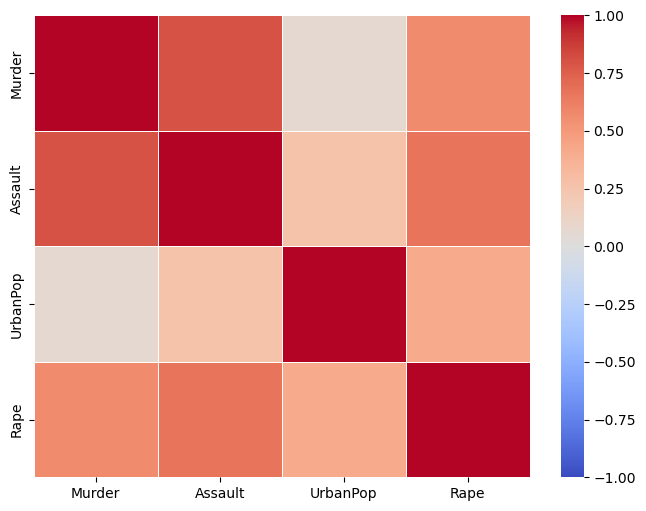

In [99]:
plt.figure(figsize=(8, 6))
sns.heatmap(inter_corr, cmap='coolwarm', fmt=".2f", linewidths=.5,vmin=-1,vmax=1)

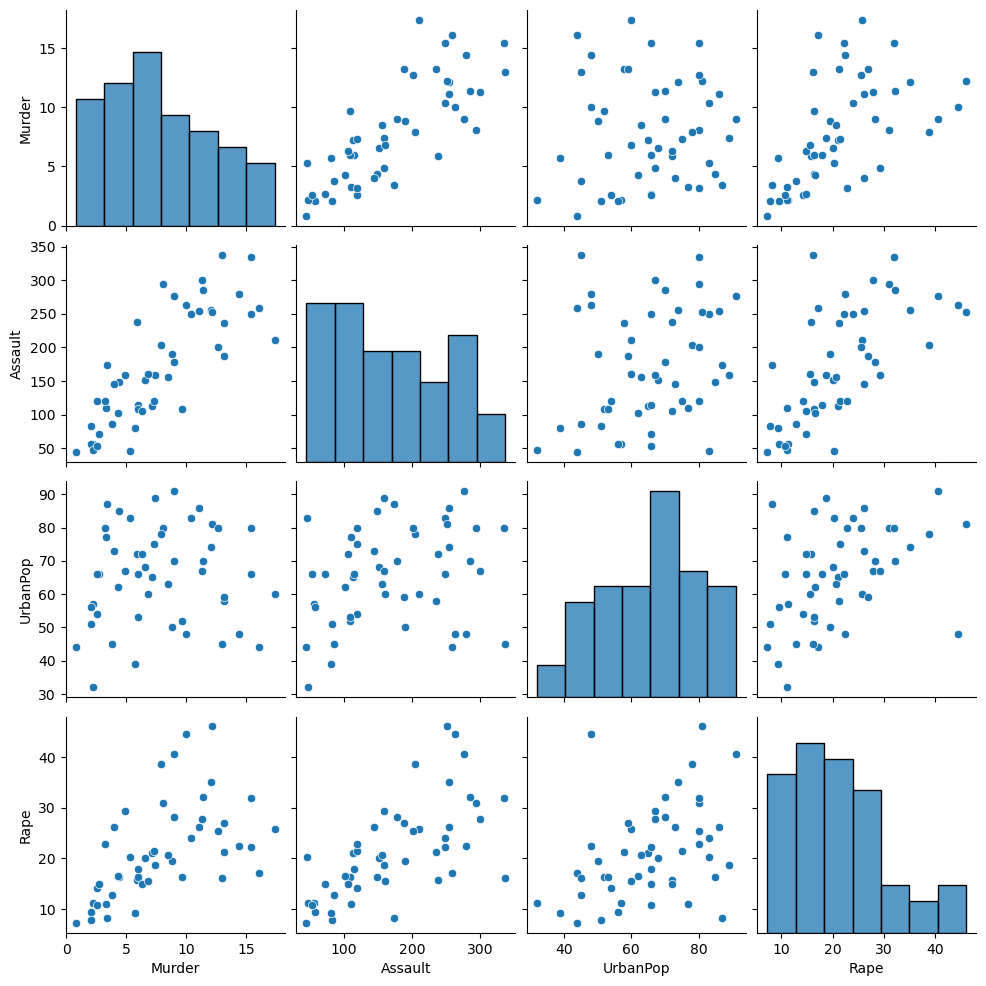

In [100]:
c=0
subset = df[_FEATURES_[c:c+4]]
sns.pairplot(subset);

A few of observations about the distributions and correlations between our four features:
1. Murder seems to be closely related to assault and, to a lesser extend, to rape.  
2. Urban population appears to be independent of the three other features.  
3. Except urban population, it is difficult to assume the other features are normally distributed.

Based on observations (1) and (2), I think the three features I would select are urban pop, murder and rape.  (I also expect that two-dimensional PCA will have one component capturing the three crime frequencies and another capturing the population.)

Based on observation (3), I am going to use MinMax scaler for the three crime frequencies and a standardscaler for the population.

## Preprocessing

I am going to be dealing with two sets of features.  For both, we will scale all features as prescribed above.  Then, for the first feature set, I will use PCA to map my four dimensional feature space to a 2-dimensional space.  For the second set, I will simply select the most important features (also discussed above).  

In [101]:
ALL_SCALE = False
scaler_frequency = MinMaxScaler()
scaler_population = StandardScaler()

scaled_frequency = scaler_frequency.fit_transform(df[['Murder','Assault','Rape']])
scaled_pop = scaler_population.fit_transform(df[['UrbanPop']])

Note that parts of the anlaysis changes pretty significantly if we apply a standard scaller to the frequency features as well.  From my understanding, this isn't exactly appropriate since we do not know if these features are normal. (Per cursory research on MinMaxScaler vs StandardScaler.)

In [102]:
if ALL_SCALE:
    scaler_frequency = StandardScaler()
    scaler_population = StandardScaler()

    scaled_frequency = scaler_frequency.fit_transform(df[['Murder','Assault','Rape']])
    scaled_pop = scaler_population.fit_transform(df[['UrbanPop']])

In [103]:
X_scaled = pd.DataFrame(np.hstack([scaled_frequency,scaled_pop]),columns=['Murder','Assault','Rape','UrbanPop'])

In [104]:
X_selected = X_scaled[['Murder','Rape','UrbanPop']]

In [105]:
pca = PCA(n_components=2)
X_transformed = pd.DataFrame(pca.fit_transform(X_scaled),columns=['PComp_1','PComp_2'])

In [106]:
X_transformed.head(5)

PComp_1   PComp_2
0 -0.493273  0.408960
1 -1.117807  0.687820
2  1.062325  0.275149
3 -1.071533  0.190331
4  1.845350  0.281774

In [107]:
v1,v2 = pca.explained_variance_ratio_
print(f'PC 1 retains {v1:.2f} and PC 2 retains {v2:.2f}')

PC 1 retains 0.84 and PC 2 retains 0.13


So a lot of the info is preserved in just these two components....

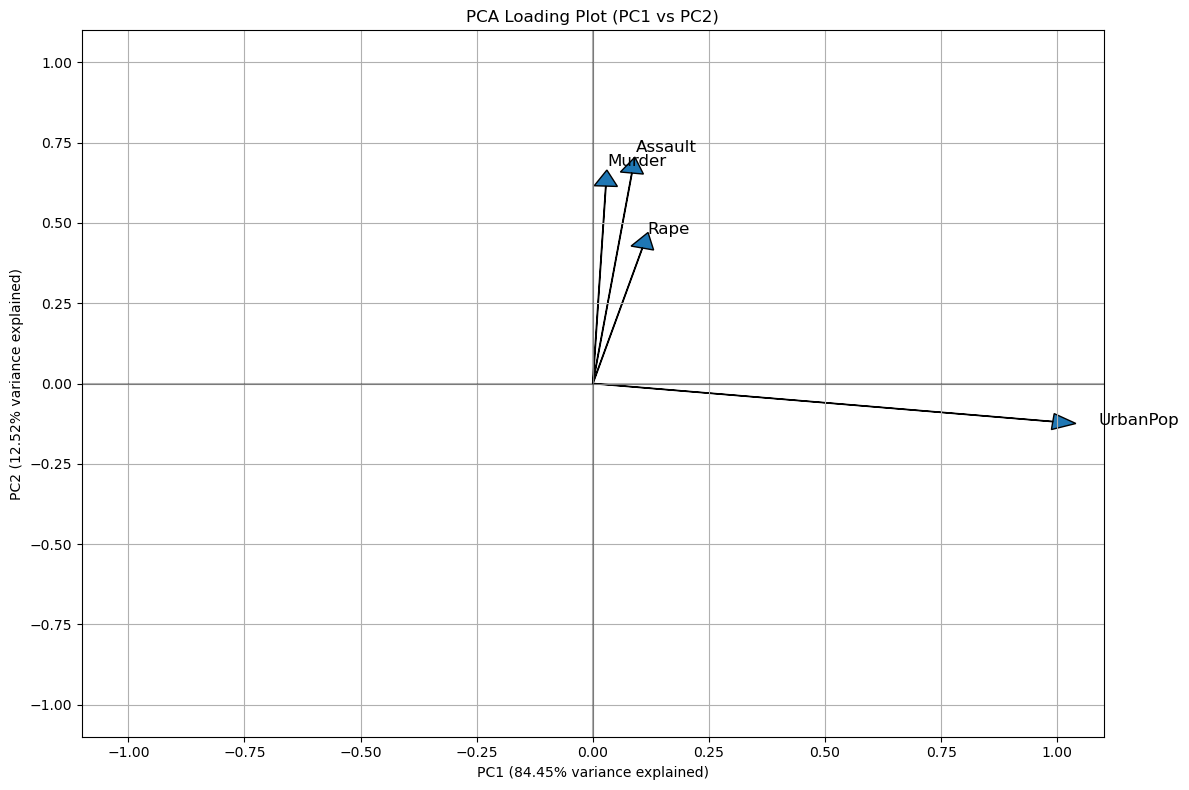

In [108]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(2)],
    index=_FEATURES_
)

# Visualize the loadings for the first two PCs
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Murder','Assault','Rape','UrbanPop']):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0]*1.1, loadings.iloc[i, 1]*1.1, feature, fontsize=12)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title('PCA Loading Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.tight_layout()
plt.show()

This basically confirms what we had anticipated: Urban population is largely independent and explains a lot of the secondary variation while, the frequency metrics largely work together with some deviation from rape stats.

## Model Exploration

## Tunning

In [109]:
bic_scores = []
aic_scores = [] #Because the bic is acting so oddly; want to check to see how much of a factor is the limited dataset size.
wcss = []
k_values = range(1,15)

In [110]:
for k in k_values:
    kmm = KMeans(n_clusters=k,random_state=42,n_init=25)  #more initializations to see if we can get out of these weird BIC/AIC scores.
    gmm = GaussianMixture(n_components=k,random_state=42,n_init=25)  #more initializations to see if we can get out of these weird BIC/AIC scores.
    kmm.fit(X_selected)
    gmm.fit(X_selected)
    bic_scores.append(gmm.bic(X_selected))
    aic_scores.append(gmm.aic(X_selected))
    wcss.append(kmm.inertia_)

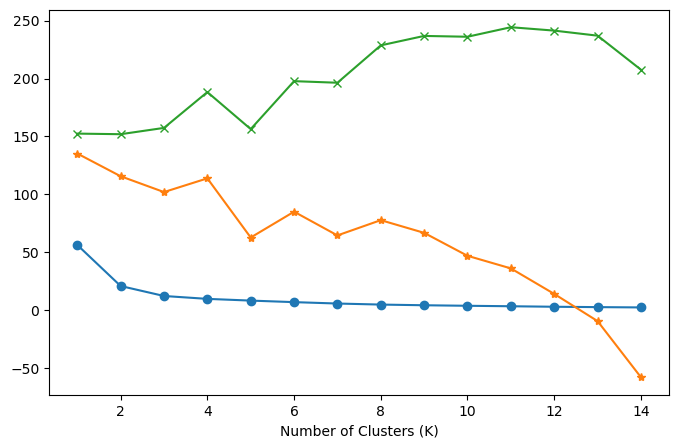

In [111]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1,15),wcss,marker='o',linestyle='-')
plt.plot(range(1,15),aic_scores,marker='*',linestyle='-')
plt.plot(range(1,15),bic_scores,marker='x',linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.show()

In [112]:
print('Clusters under GMM (w/ BIC):',1 + np.argmin(bic_scores))
print('Clusters under GMM (w/ AIC):',1 + np.argmin(aic_scores))
print('Clusters under K-Means:',2) # Could be three...

Clusters under GMM (w/ BIC): 2
Clusters under GMM (w/ AIC): 14
Clusters under K-Means: 2


Again but with the pca transformed data

In [113]:
bic_scores = []
aic_scores = []
wcss = []
k_values = range(1,15)

In [114]:
for k in k_values:
    kmm = KMeans(n_clusters=k,random_state=42,n_init=25) #more initializations to see if we can get out of these weird BIC/AIC scores.
    gmm = GaussianMixture(n_components=k,random_state=42,n_init=25)  #more initializations to see if we can get out of these weird BIC/AIC scores.
    kmm.fit(X_transformed)
    gmm.fit(X_transformed)
    bic_scores.append(gmm.bic(X_transformed))
    aic_scores.append(gmm.aic(X_transformed))
    wcss.append(kmm.inertia_)

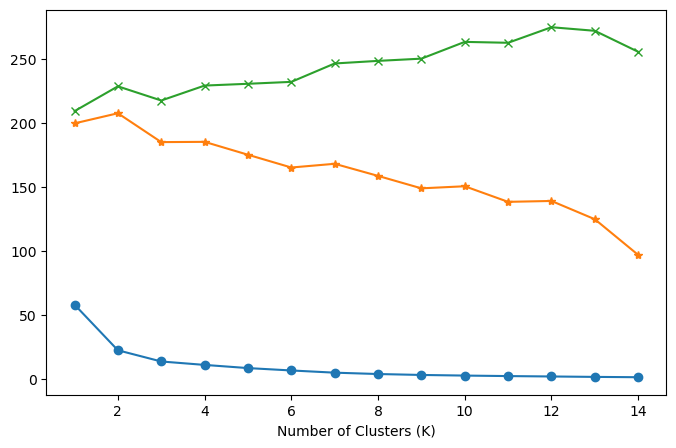

In [115]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1,15),wcss,marker='o',linestyle='-')
plt.plot(range(1,15),aic_scores,marker='*',linestyle='-')
plt.plot(range(1,15),bic_scores,marker='x',linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.show()

In [116]:
print('Clusters under GMM (w/ BIC):',1 + np.argmin(bic_scores))
print('Clusters under GMM (w/ AIC):',1 + np.argmin(aic_scores))
print('Clusters under K-Means:', 2) # Could be 3...

Clusters under GMM (w/ BIC): 1
Clusters under GMM (w/ AIC): 14
Clusters under K-Means: 2


## Final Training
I am going to use k = 2 for both KNN and GMM.  I think KNN could be argued for that anyways, and I do not believe the Gaussian mixtures are converging properly.  

I am also going to go with just looking at the pca-applied data since it will make visualizations helpful.

In [117]:
# Optimal k
optimal_k =  2
gmm = GaussianMixture(n_components=optimal_k,random_state=42,n_init=25)
kmm = KMeans(n_clusters=optimal_k,random_state=42,n_init=25)
# fit the models
gmm.fit(X_transformed)
kmm.fit(X_transformed)
# Assign probabilities to each cluster
gmm_predictions = gmm.predict(X_transformed)
kmm_predictions = kmm.predict(X_transformed)

X_transformed['GMM_Cluster'] = gmm_predictions
X_transformed['KMeans_Cluster'] = gmm_predictions

## Analysis

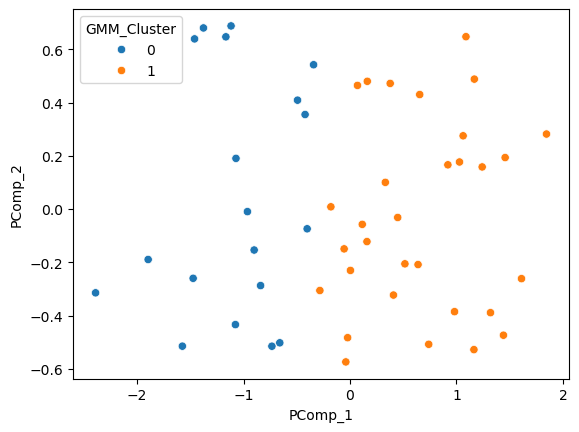

In [118]:
sns.scatterplot(data=X_transformed,x='PComp_1',y='PComp_2',hue='GMM_Cluster');

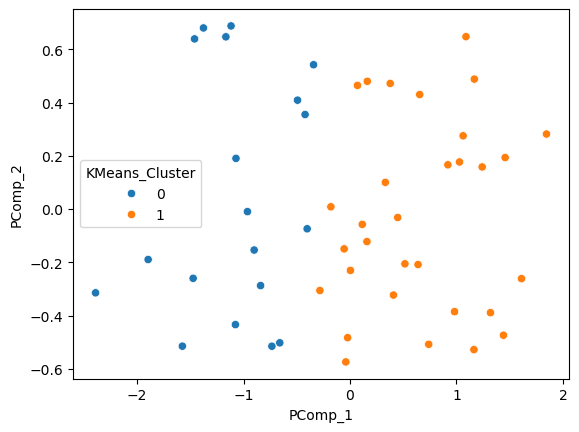

In [119]:
sns.scatterplot(data=X_transformed,x='PComp_1',y='PComp_2',hue='KMeans_Cluster');

Eyeballing it.  There is no disagreement between these clusterings which makes sense, the PCA application does an excellent job of seperating the two classes.  How confident is the mixture model on these classes.

In [120]:
X_transformed['GMM_Likelihood'] = gmm.predict_proba(X_transformed[['PComp_1','PComp_2']]).max(axis=1)

In [121]:
X1 = X_transformed[X_transformed['GMM_Cluster']==0]
X2 = X_transformed[X_transformed['GMM_Cluster']==1]

Probabilities assigned for cluster 1.

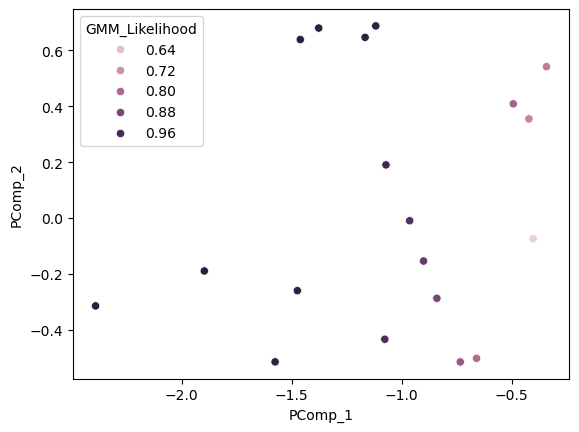

In [122]:
sns.scatterplot(data=X1,x='PComp_1',y='PComp_2',hue='GMM_Likelihood');

Probabilities Assigned for cluster 2.

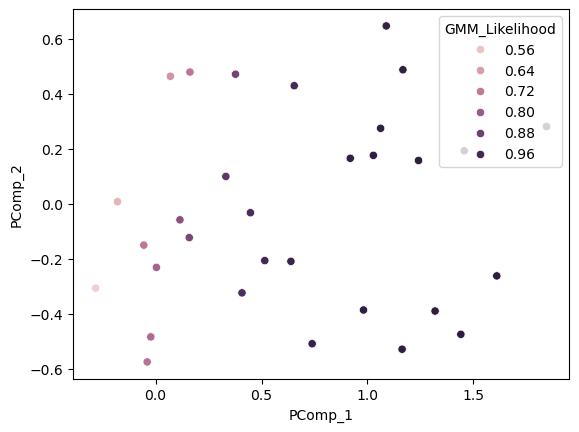

In [123]:
sns.scatterplot(data=X2,x='PComp_1',y='PComp_2',hue='GMM_Likelihood');

Confidence spreads as expected for both clusterings.